# Mental illness prediction from microbiome structure using ML

It's well known that somatic disruption of the gut and microbiome strucyture is correlated (IBD, CRC, Neoplasms).

But how about mental illness?

In [245]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import zscore
import random
from pycaret.classification import *
from scipy.stats import kruskal

In [151]:
# # Download abundance data from GMrepo

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/superkingdom2descendents.txt.gz", "superkingdom2descendents.txt.gz")
# print("taxonomy table download finished)

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/samples_loaded.txt.gz", "samples_loaded.txt.gz")
# print("sample table download finished)

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/sample_to_run_info.txt.gz", "sample_to_run_info.txt.gz")
# print("sample run download finished)
      
# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/species_abundance.txt.gz", "species_abundance.txt.gz")
# print("abundance table download finished)

In [130]:
#import data

abundance_raw = pd.read_table("species_abundance.txt")
taxonomy_table = pd.read_table("superkingdom2descendents.txt")
sample_table = pd.read_table("samples_loaded.txt")
run_table = pd.read_table("sample_to_run_info.txt", dtype = 'str')

In [131]:
# using only genus for this project

abundance_genus  = abundance_raw[abundance_raw['taxon_rank_level'].str.contains('genus', case=False)]

In [132]:
# reformat: rownames are samples and colnames are taxa

pivoted_df = abundance_genus.pivot_table(index='loaded_uid', columns='ncbi_taxon_id', values='relative_abundance', fill_value=0)

In [133]:
# rename colnames with actual genus names

# Replace blanks with underscores in the scientific_name column
taxonomy_table['scientific_name'] = taxonomy_table['scientific_name'].str.replace(' ', '_')

# Create a mapping between ncbi_taxon_id and scientific_name
mapping = dict(zip(taxonomy_table['ncbi_taxon_id'], taxonomy_table['scientific_name']))

# Rename columns in pivoted_df based on the mapping
pivoted_df.rename(columns=mapping, inplace=True)

In [134]:
pivoted_df #taxonomy table is incomplete... must complete later with newer ncbi tax tables

ncbi_taxon_id,-1,Azorhizobium,Cellvibrio,Dictyoglomus,Methylophilus,Pelobacter,Phenylobacterium,Shewanella,Myxococcus,Stigmatella,...,2211641,2212691,2212731,2282523,2282740,2282741,2282742,2304691,2304692,2529408
loaded_uid,,,,,,,,,,,,,,,,,,,,,
1,0.29633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.36680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.13739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.32762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52855,9.70667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52856,1.01729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52857,3.61897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
#merge metadata into a single df

metadata_df = pd.merge(run_table, sample_table, left_on='run_id', right_on='accession_id')

In [136]:
metadata_df

,checking,project_id,our_project_id,sample_name,original_sample_description,curated_sample_description,run_id,sample_id,second_sample_id,experiment_type,...,Antibiotics.Dose,Days.Without.Antibiotics.Use,uid,accession_id,data_type,tool_used,results_version,last_updated,QCStatus,QCMessage
0,1,PRJDB4360,NaN,Japanese001,Healthy Japanese gut microbiota,NaN,DRR048993,NaN,SAMD00042843,Amplicon,...,NaN,NaN,6339,DRR048993,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
1,1,PRJDB4360,NaN,Japanese002,Healthy Japanese gut microbiota,NaN,DRR048994,NaN,SAMD00042844,Amplicon,...,NaN,NaN,6340,DRR048994,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
2,1,PRJDB4360,NaN,Japanese003,Healthy Japanese gut microbiota,NaN,DRR048995,NaN,SAMD00042845,Amplicon,...,NaN,NaN,6341,DRR048995,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
3,1,PRJDB4360,NaN,Japanese004,Healthy Japanese gut microbiota,NaN,DRR048996,NaN,SAMD00042846,Amplicon,...,NaN,NaN,6342,DRR048996,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
4,1,PRJDB4360,NaN,Japanese005,Healthy Japanese gut microbiota,NaN,DRR048997,NaN,SAMD00042847,Amplicon,...,NaN,NaN,6343,DRR048997,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53303,1,PRJNA215106,NaN,F34_CY,Functional metagenomic selections were perform...,NaN,SRR961853,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6008,SRR961853,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53304,1,PRJNA215106,NaN,F34_PE,Functional metagenomic selections were perform...,NaN,SRR961854,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6060,SRR961854,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53305,1,PRJNA215106,NaN,F34_TE,Functional metagenomic selections were perform...,NaN,SRR961855,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,7342,SRR961855,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53306,1,PRJNA215106,NaN,F34_TR,Functional metagenomic selections were perform...,NaN,SRR961856,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6054,SRR961856,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN


### Data cleaning

In [137]:
## metadata cleaning

# 1) Remove rows where QCStatus is equal to 0 (didn't pass quality filter)
metadata_df = metadata_df[metadata_df['QCStatus'] != 0]

# 2) Remove rows with a phenotype value_count < 100 (too few samples for robust ML)
phenotype_counts = metadata_df['phenotype'].value_counts()
phenotypes_to_keep = phenotype_counts[phenotype_counts >= 100].index
metadata_df = metadata_df[metadata_df['phenotype'].isin(phenotypes_to_keep)]

# 3) rename healthy, health and Normal to Healthy; rename IBD synonyms
metadata_df['phenotype'] = metadata_df['phenotype'].replace(['healthy', 'Health', 'Normal'], 'Healthy')
metadata_df['phenotype'] = metadata_df['phenotype'].replace(['IBD', 'Inflamatory Bowel Diseases'], 'Inflamatory Bowel Disease')

# 4) Find and remove duplicated rows (excluding the 'phenotype' column)

#duplicated uids to filter from abundance table
non_phenotype_columns = metadata_df.columns.difference(['phenotype'])

duplicated_uids = metadata_df[metadata_df.duplicated(subset=non_phenotype_columns, keep=False)]['uid']
duplicated_uids = duplicated_uids.unique()

duplicated_rows = metadata_df.duplicated(subset=non_phenotype_columns, keep=False)
metadata_df = metadata_df[~duplicated_rows]

In [138]:
## abundance cleaning

# 1) exclude data uids from the abundance table that are not in the metadata table
uids_to_keep = metadata_df["uid"]
pivoted_df_filtered = pivoted_df.loc[uids_to_keep]

# 2) remove unknown column
pivoted_df_filtered = pivoted_df_filtered.iloc[:, 1:]

In [139]:
# check

if len(metadata_df) == len(pivoted_df_filtered) and (metadata_df["uid"] == pivoted_df_filtered.index).all():
    print("\nMetadata and abundance tables are the same length and have the same content in the same order 👍\n")
else:
    print("\ngrab a coffee\n")


Metadata and abundance tables are the same length and have the same content in the same order 👍



In [140]:
#reset indexes for future compatibility

metadata_df = metadata_df.reset_index(drop=True)
pivoted_df_filtered = pivoted_df_filtered.reset_index(drop=True)

In [141]:
pivoted_df_filtered

ncbi_taxon_id,Azorhizobium,Cellvibrio,Dictyoglomus,Methylophilus,Pelobacter,Phenylobacterium,Shewanella,Myxococcus,Stigmatella,Cystobacter,...,2211641,2212691,2212731,2282523,2282740,2282741,2282742,2304691,2304692,2529408
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.005849,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27576,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27577,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27578,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27579,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploratory Data Analysis

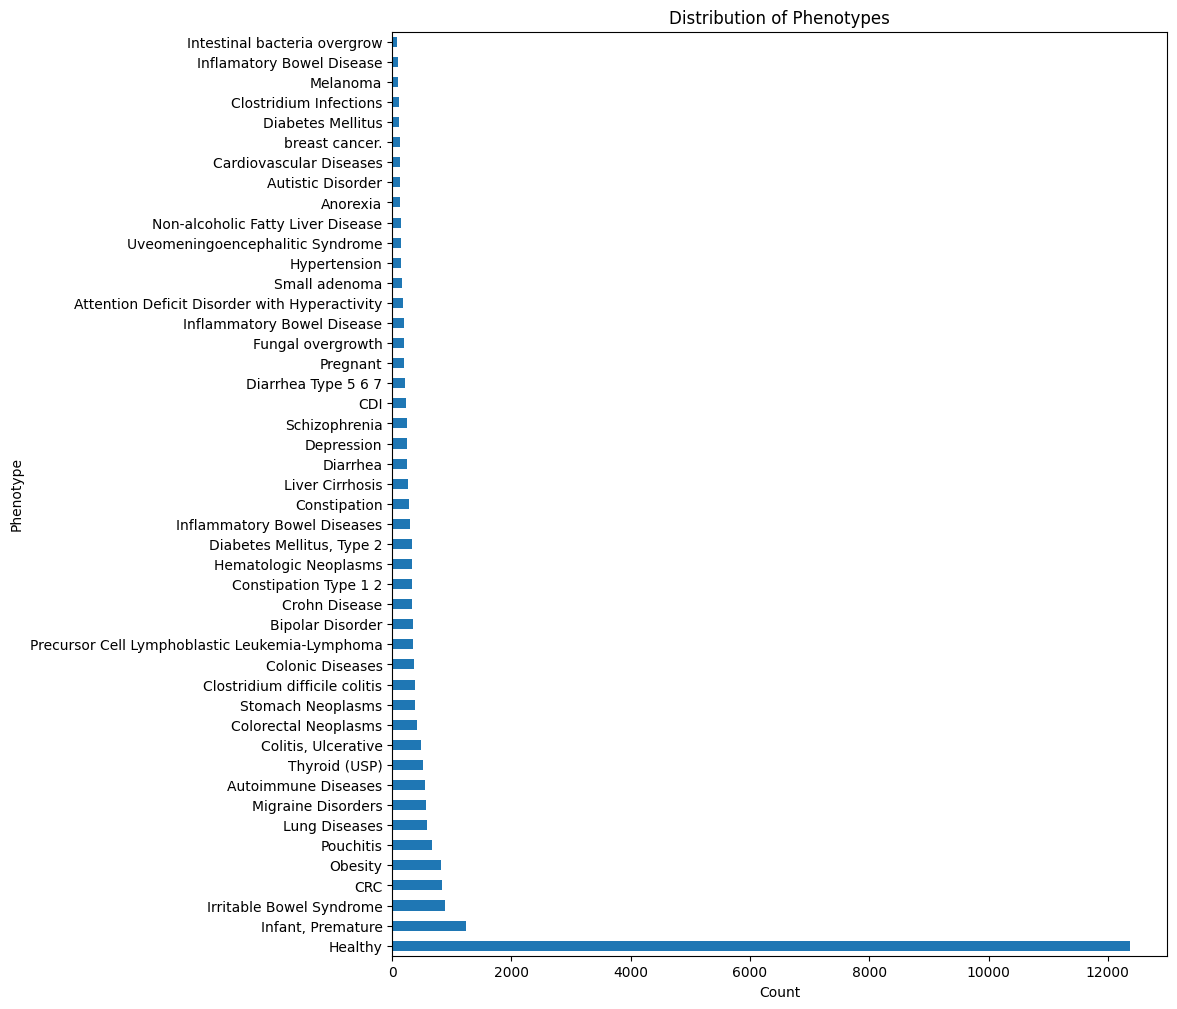

In [204]:
# plot phenotype counts

plt.figure(figsize=(10, 12))

metadata_df['phenotype'].value_counts().plot(kind='barh')

plt.xlabel('Count')
plt.ylabel('Phenotype')
plt.title('Distribution of Phenotypes')

plt.show()

Heavily unbalanced data.

### PCA of healthy samples

In [143]:
#subset healthy samples from both dfs

healthy_metadata = metadata_df[metadata_df["phenotype"] == "Healthy"]
pivoted_df_Healthy = pivoted_df_filtered.loc[healthy_metadata.index] #use healthy_metadata index to subset pivoted_df_filtered by the index

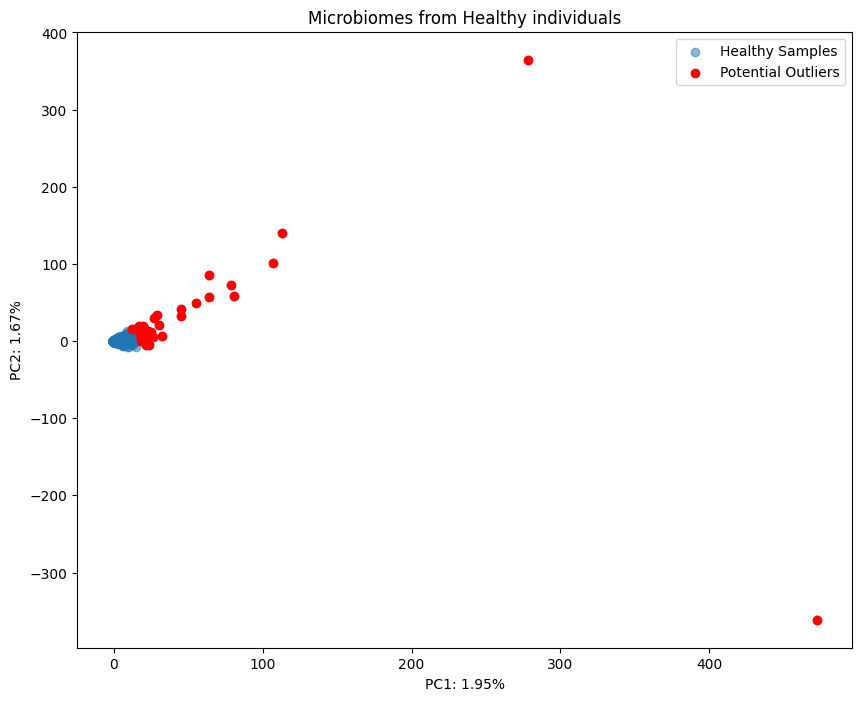

In [144]:
# Convert column names to strings
pivoted_df_Healthy.columns = pivoted_df_Healthy.columns.astype(str)

# Standardize data
scaler = StandardScaler()
pivoted_df_Healthy_standardized = scaler.fit_transform(pivoted_df_Healthy)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivoted_df_Healthy_standardized)

# Create a DataFrame with standardized PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Calculate Z-scores for each PC
z_scores = zscore(pca_df)

# Set a threshold for Z-scores to identify outliers (e.g., threshold = 3)
outlier_threshold = 3
outliers = (z_scores > outlier_threshold).any(axis=1)

# Identify outlier samples
outlier_samples = pca_df[outliers]

# Scatter plot of standardized PCA results
plt.figure(figsize=(10, 8))

# Show the percentage of variation explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
plt.title(f'Microbiomes from Healthy individuals')
plt.xlabel(f'PC1: {explained_var_ratio[0]*100:.2f}%')
plt.ylabel(f'PC2: {explained_var_ratio[1]*100:.2f}%')

# Scatter plot of standardized PCA results
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, label='Healthy Samples')
plt.scatter(outlier_samples['PC1'], outlier_samples['PC2'], color='red', label='Potential Outliers')

plt.legend()
plt.show()


In [145]:
outliers

0        False
1        False
2        False
3        False
4        False
         ...  
12371    False
12372    False
12373    False
12374    False
12375    False
Length: 12376, dtype: bool

### Remove outliers from healthy dataset

In [146]:
# Reset the index on outliers Series
outliers_reset = outliers.reset_index(drop=True)

# Filter rows in both DataFrames based on outliers_reset Series
pivoted_df_Healthy = pivoted_df_Healthy_reset[~outliers_reset]
healthy_metadata = healthy_metadata_reset[~outliers_reset]

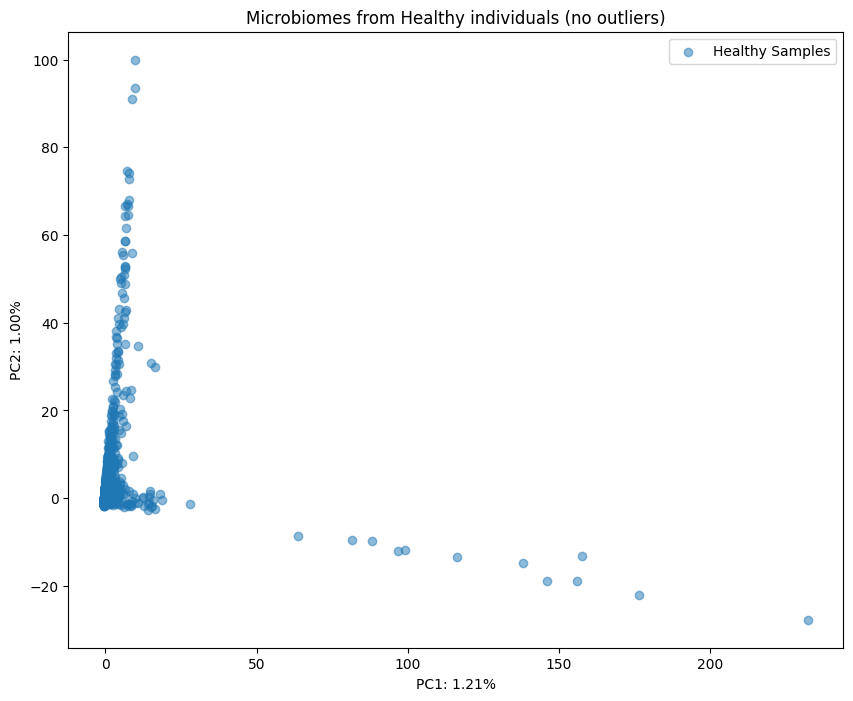

In [147]:
# Convert column names to strings
pivoted_df_Healthy.columns = pivoted_df_Healthy.columns.astype(str)

# Standardize data
scaler = StandardScaler()
pivoted_df_Healthy_standardized = scaler.fit_transform(pivoted_df_Healthy)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivoted_df_Healthy_standardized)

# Create a DataFrame with standardized PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Scatter plot of standardized PCA results
plt.figure(figsize=(10, 8))

# Show the percentage of variation explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
plt.title(f'Microbiomes from Healthy individuals (no outliers)')
plt.xlabel(f'PC1: {explained_var_ratio[0]*100:.2f}%')
plt.ylabel(f'PC2: {explained_var_ratio[1]*100:.2f}%')

# Scatter plot of standardized PCA results
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, label='Healthy Samples')

plt.legend()
plt.show()

Removing outliers made a big difference!

### PCA of all non healthy samples

In [148]:
#subset healthy samples from both dfs

non_healthy_metadata = metadata_df[metadata_df["phenotype"] != "Healthy"]
pivoted_df_non_Healthy = pivoted_df_filtered.loc[non_healthy_metadata.index] #use non_healthy_metadata index to subset pivoted_df_filtered by the index

In [149]:
# phenotypes: Separate labels into "Healthy" and "Non-Healthy"

phenotype_labels_healthy = healthy_metadata[["phenotype", "uid"]]
phenotype_labels_non_healthy = non_healthy_metadata[["phenotype", "uid"]]

In [151]:
# Reset indexes

phenotype_labels_healthy = phenotype_labels_healthy.reset_index(drop=True)

pivoted_df_non_Healthy = pivoted_df_non_Healthy.reset_index(drop=True)
phenotype_labels_non_healthy = phenotype_labels_non_healthy.reset_index(drop=True)

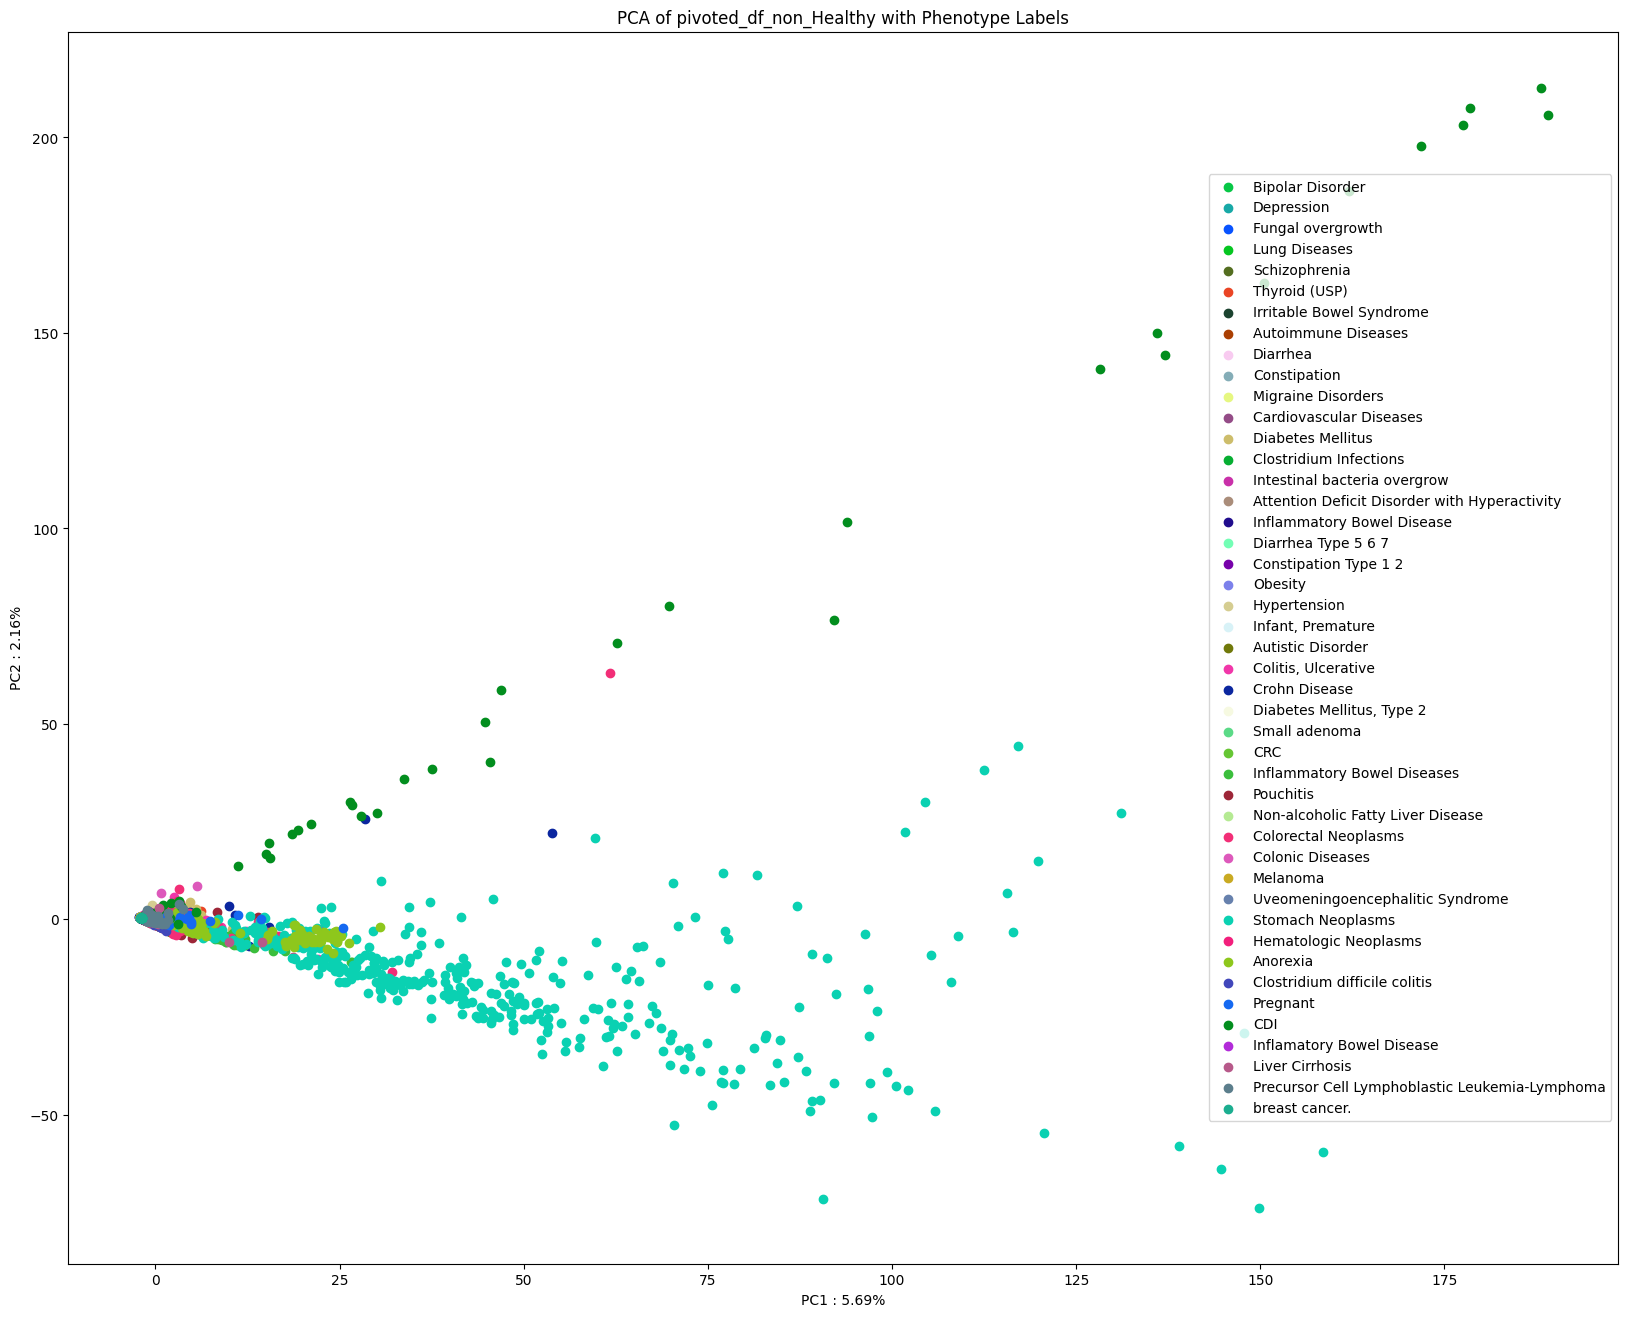

In [213]:
random.seed(420)

# Convert column names to strings
pivoted_df_non_Healthy.columns = pivoted_df_non_Healthy.columns.astype(str)

# Standardize the data
scaler = StandardScaler()
pivoted_df_non_Healthy_standardized = scaler.fit_transform(pivoted_df_non_Healthy)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivoted_df_non_Healthy_standardized)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Concatenate with labels
pca_df_with_labels = pd.concat([pca_df, phenotype_labels_non_healthy['phenotype']], axis=1)

# Use unique labels as categories
unique_labels = pca_df_with_labels['phenotype'].unique()

# Generate len(unique_phenotypes) random colors
colors = [tuple(random.uniform(0, 1) for _ in range(3)) for _ in range(len(unique_labels))]

# Create a color mapping for each unique label
label_colors = {label: colors[i] for i, label in enumerate(unique_labels)}

# Plot the PCA results with labels and colors
plt.figure(figsize=(20, 16))
for label, color in label_colors.items():
    subset = pca_df_with_labels[pca_df_with_labels['phenotype'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, color=color)

# Display percentage of variance explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
pc1_var = explained_var_ratio[0]* 100
pc2_var = explained_var_ratio[1]* 100

plt.title('PCA of pivoted_df_non_Healthy with Phenotype Labels')
plt.xlabel(f'PC1 : {round(pc1_var, 2)}%')
plt.ylabel(f'PC2 : {round(pc2_var, 2)}%')
plt.legend()


plt.show()

Some clear differences here: Anorexia, CDI, Stomach Neoplasms...

## Healthy vs mental ilness

In [393]:
# Subset mental illnessess

mental_illnesses = ["Bipolar Disorder", "Depression", "Schizophrenia", "Migraine Disorders", 
                   "Attention Deficit Disorder with Hyperactivity", "Autistic Disorder", "Anorexia"]

is_in_mental_illnesses = phenotype_labels_non_healthy['phenotype'].isin(mental_illnesses)

#data
subset_pivoted_df_mental_illnesses = pivoted_df_non_Healthy[is_in_mental_illnesses]

#labels
subset_mental_illnesses_phenotype_labels = phenotype_labels_non_healthy[is_in_mental_illnesses]
subset_mental_illnesses_phenotype_labels['phenotype'].unique()

array(['Bipolar Disorder', 'Depression', 'Schizophrenia',
       'Migraine Disorders',
       'Attention Deficit Disorder with Hyperactivity',
       'Autistic Disorder', 'Anorexia'], dtype=object)

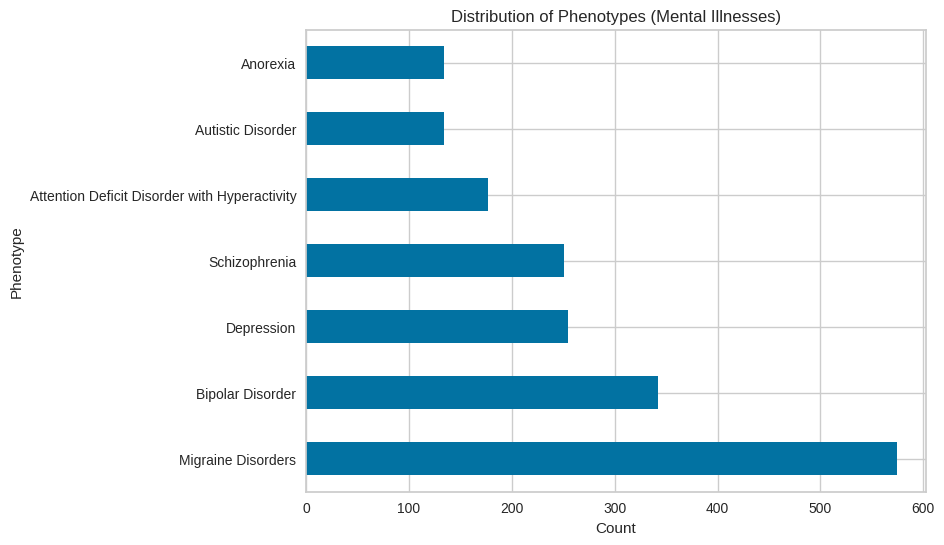

In [394]:
# plot phenotype counts

plt.figure(figsize=(8, 6))

subset_mental_illnesses_phenotype_labels['phenotype'].value_counts().plot(kind='barh')

plt.xlabel('Count')
plt.ylabel('Phenotype')
plt.title('Distribution of Phenotypes (Mental Illnesses)')

plt.show()

In [395]:
# Concatenate mental ilnessess with healthy dfs

concatenated_pivoted_df = pd.concat([subset_pivoted_df_mental_illnesses, pivoted_df_Healthy])
concatenated_phenotype_labels = pd.concat([subset_mental_illnesses_phenotype_labels, phenotype_labels_healthy])

concatenated_pivoted_df = concatenated_pivoted_df.reset_index(drop=True)
concatenated_phenotype_labels = concatenated_phenotype_labels.reset_index(drop=True)

### PCA of mental illnessess vs healthy samples

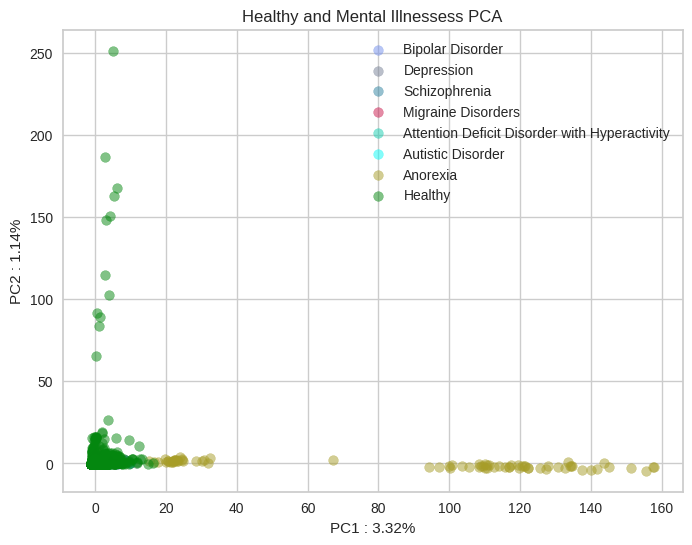

In [396]:
random.seed(11)

# Convert column names to strings
concatenated_pivoted_df.columns = concatenated_pivoted_df.columns.astype(str)

# Standardize the data
scaler = StandardScaler()
concatenated_pivoted_df_standardized = scaler.fit_transform(concatenated_pivoted_df)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(concatenated_pivoted_df_standardized)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Concatenate with labels
pca_df_with_labels = pd.concat([pca_df, concatenated_phenotype_labels['phenotype']], axis=1)

# Use unique labels as categories
unique_labels = pca_df_with_labels['phenotype'].unique()

# Generate len(unique_phenotypes) random colors
colors = [tuple(random.uniform(0, 1) for _ in range(3)) for _ in range(len(unique_labels))]

# Create a color mapping for each unique label
label_colors = {label: colors[i] for i, label in enumerate(unique_labels)}

# Plot the PCA results with labels and colors
plt.figure(figsize=(8, 6))
for label, color in label_colors.items():
    subset = pca_df_with_labels[pca_df_with_labels['phenotype'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, color=color, alpha=0.5)  # Adding alpha for transparency

# Display percentage of variance explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
pc1_var = explained_var_ratio[0]* 100
pc2_var = explained_var_ratio[1]* 100

plt.title('Healthy and Mental Illnessess PCA')
plt.xlabel(f'PC1 : {round(pc1_var, 2)}%')
plt.ylabel(f'PC2 : {round(pc2_var, 2)}%')
plt.legend()

plt.show()

Not much differentiation, except for Anorexia. This makes sense as anorexia has severe gastrointestinal consequences.

### Build a binary classifier for each disease (build loop for all the following steps!)

### 1) subset data

In [434]:
# select a disease

# ((( [IF CHANGING subset_mental_illnesses_phenotype_labels FOR phenotype_labels_non_healthy] 
# AND
# [subset_pivoted_df_mental_illnesses FOR pivoted_df_non_Healthy]
# ALL DISEASES CAN BE ACCESSED! )))

element = phenotype_labels_non_healthy['phenotype'].unique()[-5]# iterate here 
is_in_element = phenotype_labels_non_healthy['phenotype'] == (element)

# subset data
mi = pivoted_df_non_Healthy[is_in_element]
# subset labels
mi_labels = phenotype_labels_non_healthy[is_in_element]

print(element)

CDI


### 2) feature selection

In [435]:
# Initialize an empty DataFrame to store results
signif_kw_results = pd.DataFrame(columns=['Column_Name', 'P_Value'])

# Iterate through each column in pivoted_df_Healthy
for column_name in pivoted_df_Healthy.columns:
    # Check for unique values in each group
    unique_values_pivoted = pivoted_df_Healthy[column_name].unique()
    unique_values_mi = mi[column_name].unique()
    
    # If either group has only one unique value, skip the test for this column
    if len(unique_values_pivoted) > 1 and len(unique_values_mi) > 1:
        # Perform Kruskal-Wallis test
        _, p_value = kruskal(pivoted_df_Healthy[column_name], mi[column_name])
        
        # Check if p-value is less than 0.05
        if p_value < 0.05:
            # Append results to kw_results DataFrame
            signif_kw_results = signif_kw_results.append({'Column_Name': column_name, 'P_Value': p_value}, ignore_index=True)

signif_kw_results

,Column_Name,P_Value
0,Cellvibrio,9.172895e-116
1,Pelobacter,3.820888e-21
2,Phenylobacterium,6.693005e-71
3,Shewanella,3.081038e-13
4,Myxococcus,2.328322e-47
...,...,...
562,2057233,1.035294e-05
563,2070447,1.330214e-02
564,2282523,3.229415e-11
565,2282741,3.766884e-05


In [436]:
# Keep significant features

# Extract the column names to keep
columns_to_keep = signif_kw_results["Column_Name"].tolist()

# Filter columns in pivoted_df_Healthy and mi
filtered_pivoted_df_Healthy = pivoted_df_Healthy.filter(columns_to_keep, axis=1)
filtered_mi = mi.filter(columns_to_keep, axis=1)

In [437]:
#concat with healthy samples
mi_concatenated_pivoted_df = pd.concat([filtered_pivoted_df_Healthy, filtered_mi])
mi_concatenated_phenotype_labels = pd.concat([phenotype_labels_healthy, mi_labels, ])

mi_concatenated_pivoted_df = mi_concatenated_pivoted_df.reset_index(drop=True)
mi_concatenated_phenotype_labels = mi_concatenated_phenotype_labels.reset_index(drop=True)

### 3) PCA of selected disease against healthy samples

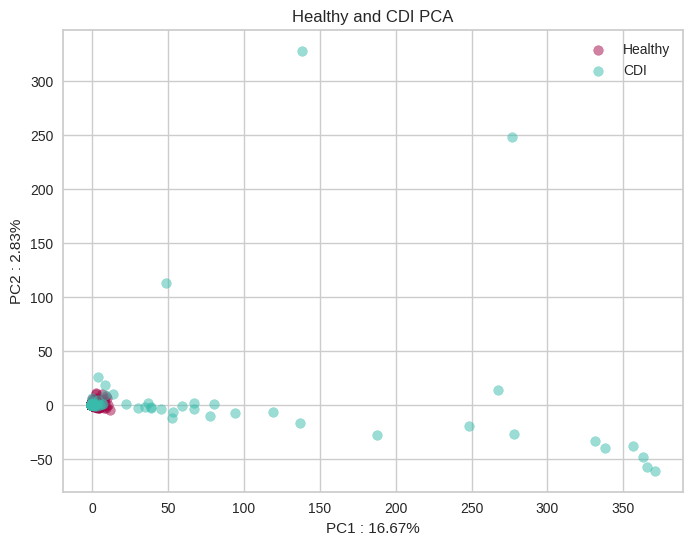

In [438]:
random.seed(42)

# Convert column names to strings
mi_concatenated_pivoted_df.columns = mi_concatenated_pivoted_df.columns.astype(str)

# Standardize the data
scaler = StandardScaler()
mi_concatenated_pivoted_df_standardized = scaler.fit_transform(mi_concatenated_pivoted_df)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(mi_concatenated_pivoted_df_standardized)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Concatenate with labels
pca_df_with_labels = pd.concat([pca_df, mi_concatenated_phenotype_labels['phenotype']], axis=1)

# Use unique labels as categories
unique_labels = pca_df_with_labels['phenotype'].unique()

# Generate len(unique_phenotypes) random colors
colors = [tuple(random.uniform(0, 1) for _ in range(3)) for _ in range(len(unique_labels))]

# Create a color mapping for each unique label
label_colors = {label: colors[i] for i, label in enumerate(unique_labels)}

# Plot the PCA results with labels and colors
plt.figure(figsize=(8, 6))
for label, color in label_colors.items():
    subset = pca_df_with_labels[pca_df_with_labels['phenotype'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, color=color, alpha=0.5)  # Adding alpha for transparency

# Display percentage of variance explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
pc1_var = explained_var_ratio[0]* 100
pc2_var = explained_var_ratio[1]* 100

plt.title(f'Healthy and {element} PCA')
plt.xlabel(f'PC1 : {round(pc1_var, 2)}%')
plt.ylabel(f'PC2 : {round(pc2_var, 2)}%')
plt.legend()

plt.show()

### 4) train ML model

In [428]:
# Calculate and print the percentage of each unique class
class_percentages = mi_concatenated_phenotype_labels["phenotype"].value_counts(normalize=True) * 100

for class_label, percentage in class_percentages.items():
    print(f"Class: {class_label}, Percentage: {percentage:.2f}%")

Class: Healthy, Percentage: 98.18%
Class: CDI, Percentage: 1.82%


In [429]:
# Replace labels with the desired mapping: Healthy always = 0 and whatever mental illness  == 1
mi_concatenated_phenotype_labels["phenotype"] = mi_concatenated_phenotype_labels["phenotype"].apply(lambda x: 0 if x == "Healthy" else 1)

In [430]:
# pycaret

exp1 = setup(mi_concatenated_pivoted_df, target=mi_concatenated_phenotype_labels["phenotype"], 
             session_id=42, remove_outliers = False, n_jobs = 6, train_size=0.7)

,Description,Value
0,Session id,42
1,Target,phenotype
2,Target type,Binary
3,Original data shape,"(12566, 568)"
4,Transformed data shape,"(12566, 568)"
5,Transformed train set shape,"(8796, 568)"
6,Transformed test set shape,"(3770, 568)"
7,Numeric features,567
8,Preprocess,True
9,Imputation type,simple


In [431]:
compare_models(exclude = ['lightgbm', 'catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9973,0.9998,0.8875,0.9607,0.9207,0.9193,0.9211,4.0420
ada,Ada Boost Classifier,0.9972,0.9975,0.8938,0.9487,0.9197,0.9183,0.9190,0.7310
gbc,Gradient Boosting Classifier,0.9936,0.9953,0.7250,0.9035,0.8024,0.7992,0.8053,3.2150
rf,Random Forest Classifier,0.9920,0.9994,0.5750,0.9789,0.7150,0.7114,0.7418,0.2540
et,Extra Trees Classifier,0.9920,0.9938,0.5750,0.9798,0.7141,0.7105,0.7415,0.5140
dt,Decision Tree Classifier,0.9914,0.8821,0.7562,0.7706,0.7610,0.7566,0.7578,0.3840
lr,Logistic Regression,0.9897,0.9942,0.5562,0.8059,0.6499,0.6451,0.6605,3.4440
knn,K Neighbors Classifier,0.9876,0.9317,0.5188,0.7346,0.6037,0.5977,0.6092,0.2450
ridge,Ridge Classifier,0.9868,0.0000,0.3125,0.9209,0.4396,0.4353,0.5086,0.0950
nb,Naive Bayes,0.9858,0.9773,0.8000,0.5914,0.6714,0.6645,0.6768,0.0960


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=6,
              num_parallel_tree=None, objective='binary:logistic', ...)